# Imports 

In [27]:
import sys
sys.path.append('../src')

from data_manager import extract_annotations
from data_manager import load_vehicle_data
from feature_manager import feature_extraction

import os
import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage import io

import pickle
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

data_path = '../data'

train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path, 'test')

H, W, C = 720, 1280, 3
N = 2020

# Dataset for vehicle recognition

In [7]:
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
train_df.head()

print(f"Training data {len(train_df)}")

Training data 2020


# Vehicle dataset extraction

100%|██████████| 2020/2020 [01:13<00:00, 27.47it/s]


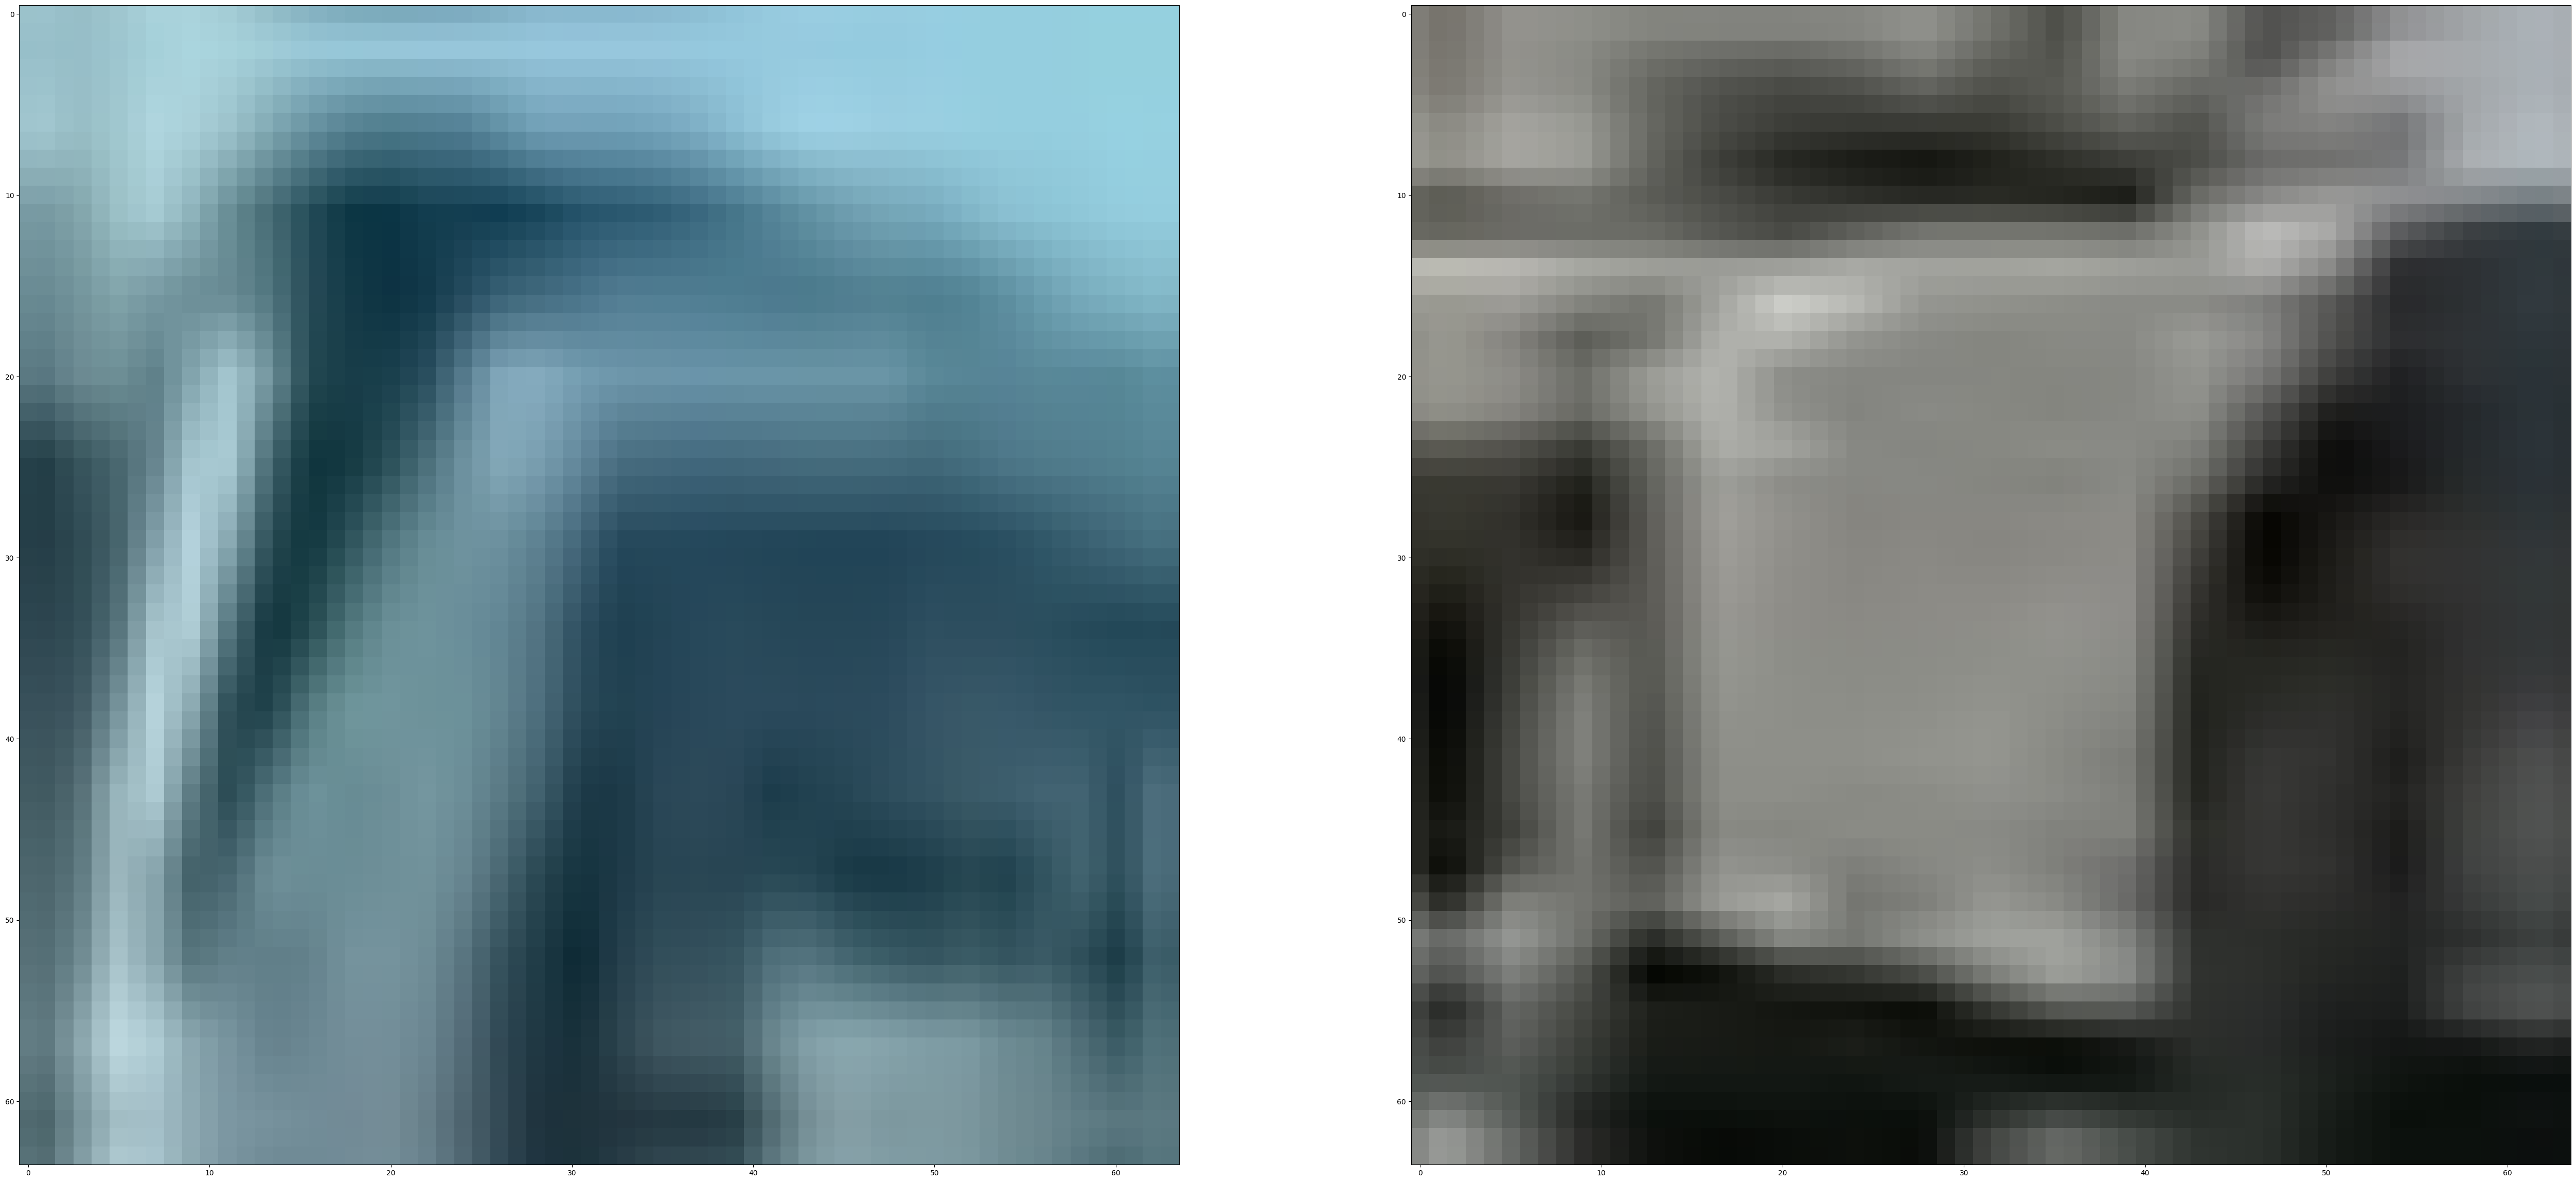

In [11]:
def extract_dataset(path, df_annotation):
    
    images = []

    for line in tqdm(range(len(df_annotation))):

        sub_images = extract_annotations(path, df_annotation, line)

        images.extend(sub_images)
    
    return np.array(images)

images = extract_dataset(data_path, train_df)

plt.figure(figsize=(64,64))

plt.subplot(1,2,1)
plt.imshow(images[random.randint(0, N)])

plt.subplot(1,2,2)
plt.imshow(images[random.randint(0, N)])

plt.show()

images.shape # (16018, 64, 64, 3)

# Non-vehicle dataset

100%|██████████| 8968/8968 [02:11<00:00, 68.32it/s]


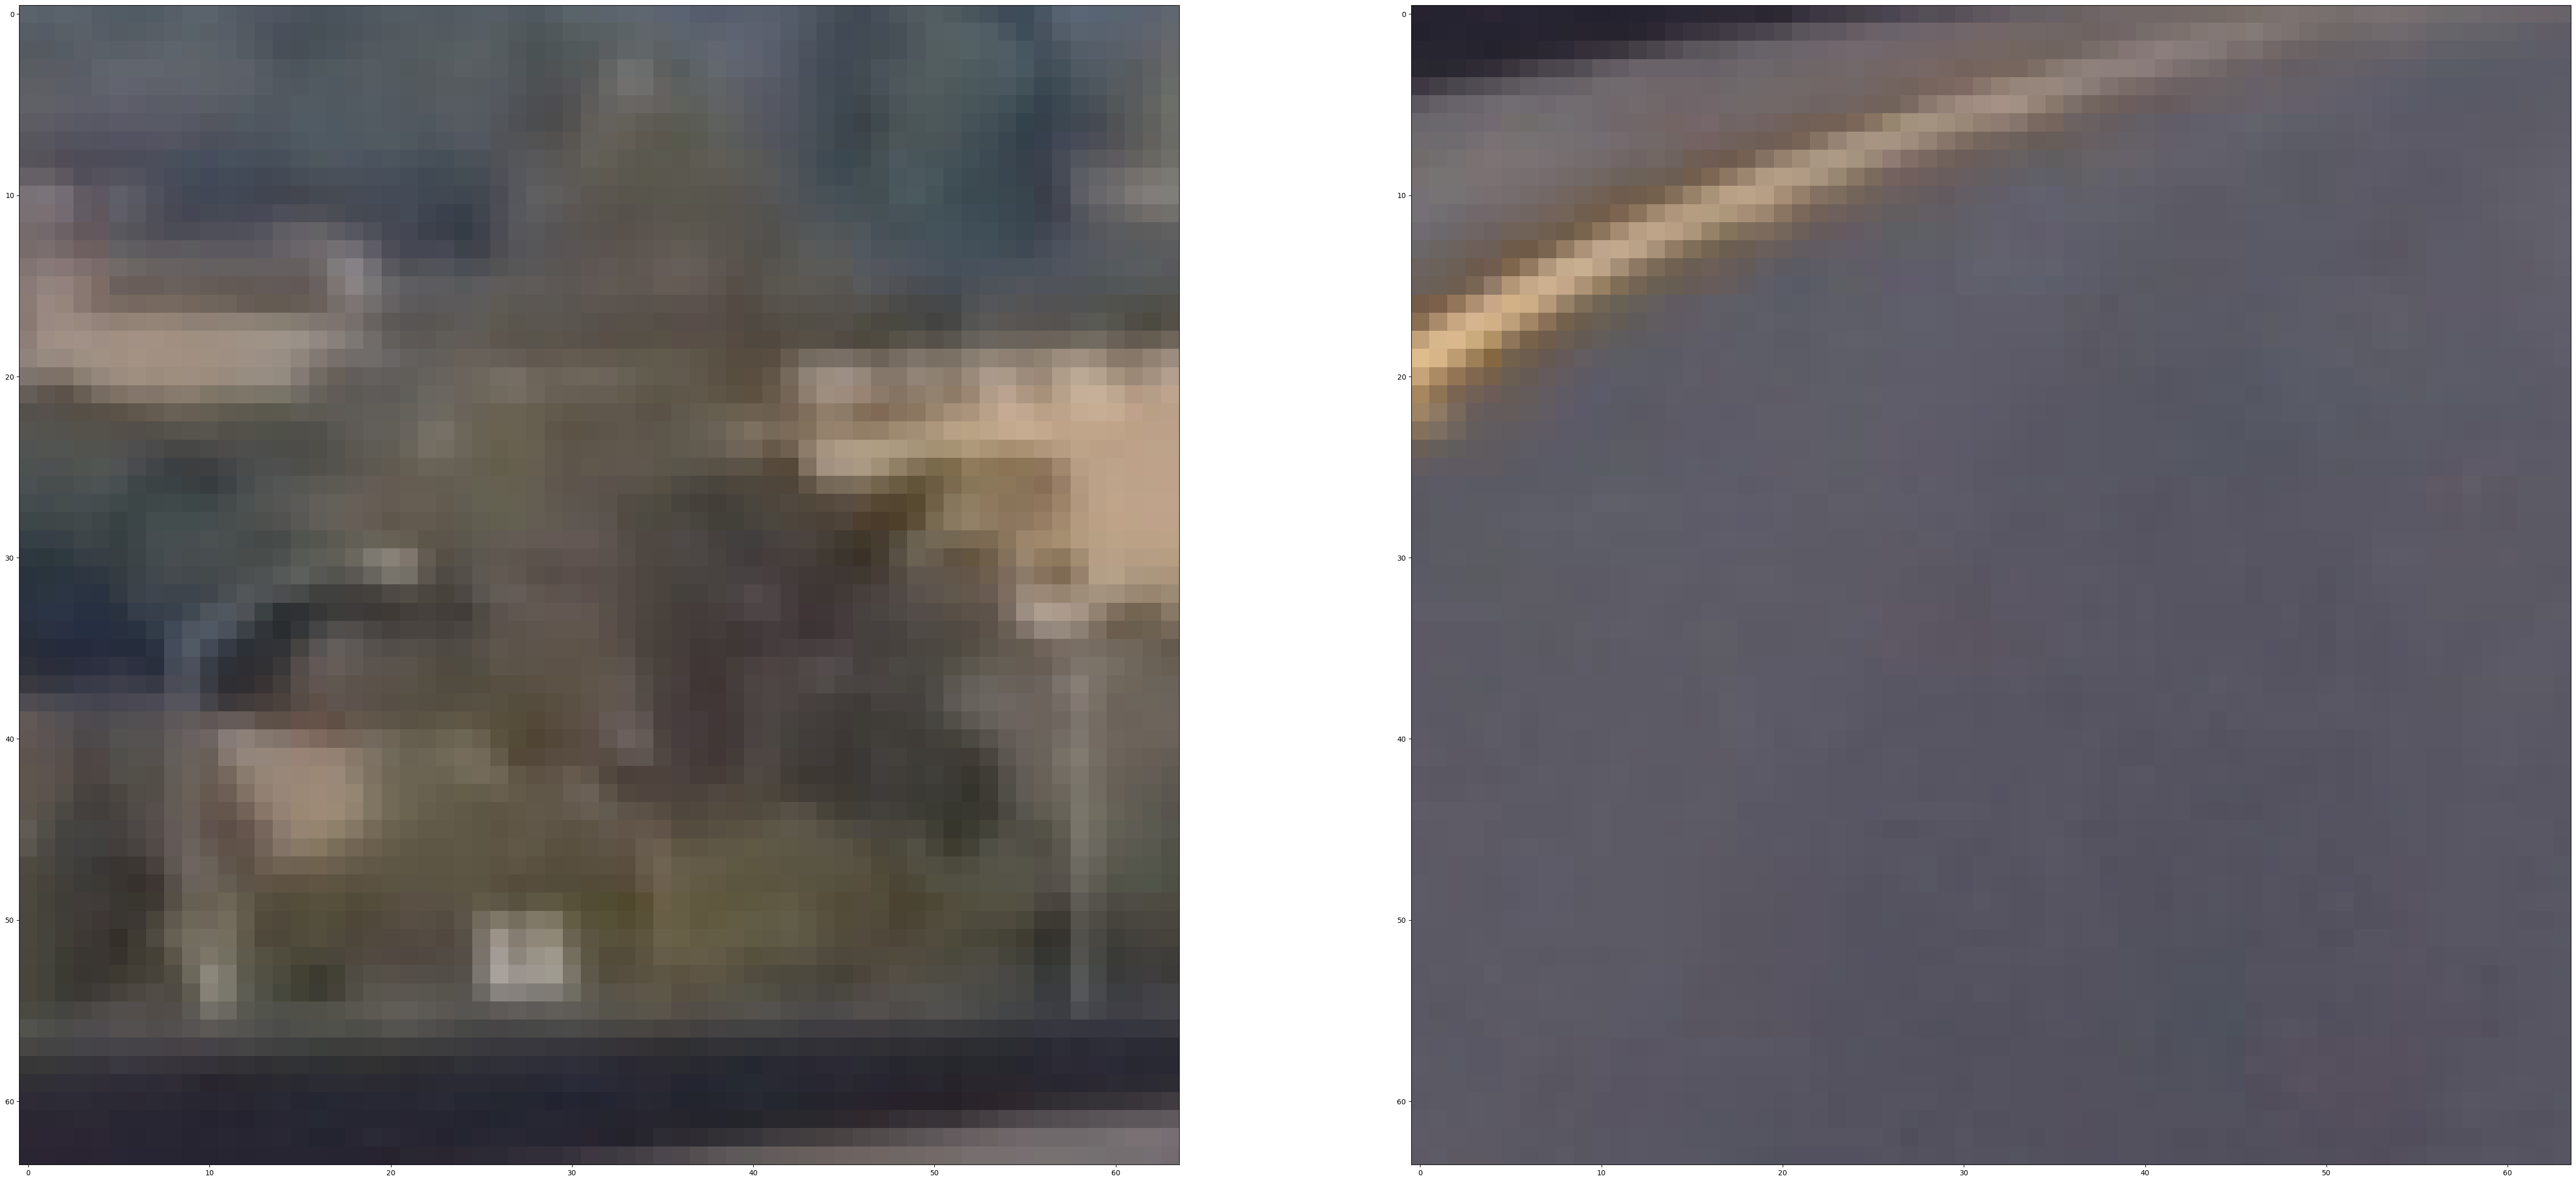

AttributeError: 'list' object has no attribute 'shape'

In [20]:
non_vehicle_image_paths, non_vehicle_labels = load_vehicle_data(data_path, 'non-vehicles')

non_vehicle_images = []
for image_path in tqdm(non_vehicle_image_paths):

    image = io.imread(image_path)
    non_vehicle_images.append(image)


plt.figure(figsize=(64,64))

plt.subplot(1,2,1)
plt.imshow(non_vehicle_images[random.randint(0, 100)])

plt.subplot(1,2,2)
plt.imshow(non_vehicle_images[random.randint(0, 100)])

plt.show()

# Build classification dataset and preprocess

In [30]:
def build_and_preprocess_classification_dataset(
    path, train_df, non_vehicle_folder,
    spatial_size,
    color_bins_n, color_bins_range,
    orientations, pixels_per_cell, cells_per_block, transform_sqrt,
    channel_axis,
    verbose=False
):

    non_vehicle_image_paths, non_vehicle_labels = load_vehicle_data(data_path, non_vehicle_folder)
    non_vehicle_images = []
    for image_path in tqdm(non_vehicle_image_paths):
        image = io.imread(image_path)
        non_vehicle_images.append(image)
    non_vehicle_images, non_vehicle_labels = np.array(non_vehicle_images), np.zeros(len(non_vehicle_images))

    if verbose:
        print(f'Non vehicle images shape: {non_vehicle_images.shape}')
        print(f'Non vehicle lables shape: {non_vehicle_labels.shape}')
        print(f"Non vehicle labels: {non_vehicle_labels[:5]}")

    vehicle_images = extract_dataset(path, train_df)
    vehicle_images = vehicle_images[np.random.choice(len(vehicle_images), size=len(non_vehicle_images), replace=False)] 
    vehicle_labels = np.ones(len(vehicle_images))

    if verbose:
        print(f'Vehicle images shape: {vehicle_images.shape}')
        print(f'Vehicle labels shape: {vehicle_labels.shape}')
        print(f"Vehicle labels: {vehicle_labels[:5]}")

    images = np.concatenate([non_vehicle_images, vehicle_images])
    labels = np.concatenate([non_vehicle_labels, vehicle_labels])

    if verbose:
        print(f'Images shape: {images.shape}')
        print(f'Labels shape: {labels.shape}')

    features = []

    for image in tqdm(images):
        frame_features = feature_extraction(
            image,
            spatial_size=spatial_size,
            color_bins_n=color_bins_n, color_bins_range=color_bins_range,
            orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
            transform_sqrt=transform_sqrt, channel_axis=channel_axis
        )
        features.append(frame_features)
    features = np.array(features)

    if verbose:
        print(f"Features shape: {features.shape}")

    X = features
    y = labels

    X_scaler = StandardScaler().fit(X)
    X_scaled = X_scaler.transform(X)

    return X_scaled, X_scaler, y

In [31]:
channel_axis = 2

orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
transform_sqrt = True

color_bins_n = 32
color_bins_range = (0, 256)

spatial_size = (32, 32)


X_scaled, X_scaler, y = build_and_preprocess_classification_dataset(
    data_path, train_df, 'non-vehicles',
    spatial_size,
    color_bins_n, color_bins_range,
    orientations, pixels_per_cell, cells_per_block, transform_sqrt,
    channel_axis,
    verbose=True
)

with open('models/new_dataset_scaler.pkl', 'wb') as file:
    pickle.dump(X_scaler, file) 


  0%|          | 0/8968 [00:00<?, ?it/s]

100%|██████████| 8968/8968 [00:18<00:00, 477.04it/s]


Non vehicle images shape: (8968, 64, 64, 3)
Non vehicle lables shape: (8968,)
Non vehicle labels: [0. 0. 0. 0. 0.]


100%|██████████| 2020/2020 [00:58<00:00, 34.33it/s]


Vehicle images shape: (8968, 64, 64, 3)
Vehicle labels shape: (8968,)
Vehicle labels: [1. 1. 1. 1. 1.]
Images shape: (17936, 64, 64, 3)
Labels shape: (17936,)


100%|██████████| 17936/17936 [01:36<00:00, 185.04it/s]


Features shape: (17936, 8460)


# Classification

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3, random_state=42
)

svc = LinearSVC()
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Test Accuracy of SVC =  1.0


In [33]:
with open('models/new_dataset_classifier.pkl', 'wb') as file:
    pickle.dump(svc, file)